# Monte Carlo Methods
## Kai Chang

In this write-up, we explore the problem of drawing samples from a heavy-tailed distribution. We apply some popular standard Monte Carlo algorithms, such as the rejection sampling method and the self-normalized importance sampling to draw samples from the Cauchy distribution. To begin with, we implement the Cauchy sampler below. 

In [2]:
import numpy as np

class cauchy(object):

    def __init__(self, gamma) -> None:
        super().__init__()
        self.gamma = gamma
    
    def draw(self,n):
        y = np.random.rand(n)
        x = self.gamma * np.tan(np.pi*(y-0.5))
        return x

    def running_mean_seq(self, n, S):
        """
        n: #iid samples to compute sample mean
        S: #independent sample sequences
        """
        sample_mat = np.random.rand(n,S)
        sample_mat = self.gamma * np.tan(np.pi*(sample_mat-0.5))
        running_means = np.zeros_like(sample_mat)
        for i in range(n):
            running_means[i,:] = np.mean(sample_mat[0:i+1,:], axis=0)
        return running_means



To see qualititive properties of $(\bar{x_n}^{(s)})_n$, we draw $S=1000$ independent sequences of $n=3000$ i.i.d. samples and plot the running means of each of the 1000 sequences. From the plot, we see that although the running means seem to be converging to something, an extremely large outlier is occasionally encountered during the sampling. This makes the "convergence" undetermined. In fact, as said in the Wikipedia entry, "the average does not converge to the mean, and so the standard Cauchy distribution does not follow the law of large numbers."

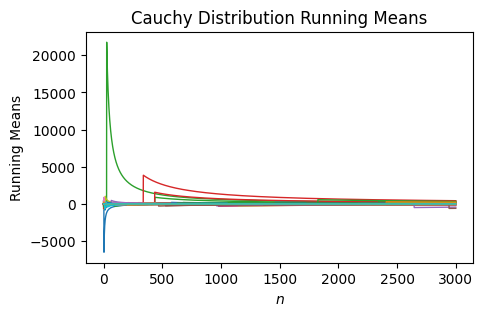

In [10]:
import matplotlib.pyplot as plt

def plot_running_means(running_means):
    S = running_means.shape[1]
    plt.figure(figsize=(5,3))
    for i in range(S):
        plt.plot(running_means[:,i], lw=1)
    plt.title('Cauchy Distribution Running Means')
    plt.ylabel('Running Means', fontsize=10)
    plt.xlabel('$n$', fontsize=10)

np.random.seed(3)
gamma = 1.5
n = 3000
S = 1000
sampler = cauchy(gamma)
running_means = sampler.running_mean_seq(n,S)
plot_running_means(running_means)

We pick $n \in \{256,512,1024,2048\}$ to examine the distribution of the sample mean computed with those number of i.i.d. Cauchy samples. For each $n$, we plot a histogram (empirical distribution) of the sample means and compute the skewness, kurtosis, and variance. We also compute several quantile estimates as presented below.

From the result, we see that the estimated moments of the Cauchy distribution does not follow a specific pattern. This can be seen more clearly when rerunning the experiments for several times as each time will give a drastically different result. This makes sense because the Cauchy distribution does not have finite moments of order ≥ 1.

The quantiles, however, have much stabler behavior. 

,n,Variance,Skewness,Kurtosis,.5 Quantile,.25 Quantile,.75 Quantile,.95 Quantile
0,256,5835.656950,29.984118,928.796355,-0.067031,-1.643662,1.448459,10.265491
1,512,10579.014008,19.559426,430.691838,-0.010593,-1.459835,1.683469,11.775635
2,1024,2939.483295,16.539640,352.390199,-0.087566,-1.478955,1.364668,11.404251
3,2048,1115.170964,12.216623,202.726237,-0.095960,-1.603612,1.368388,11.919381


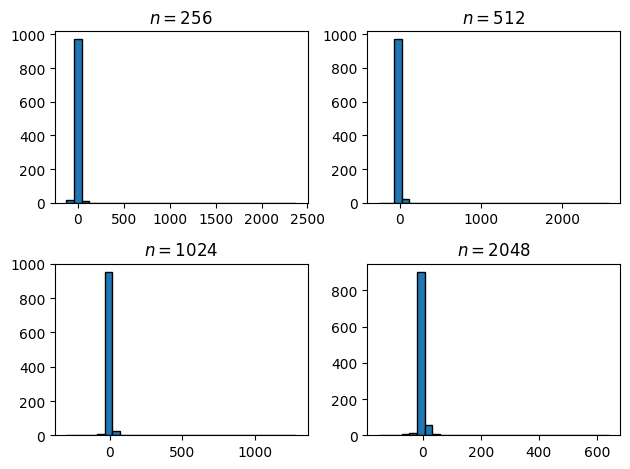

In [11]:
from scipy.stats import kurtosis, skew
import pandas as pd
from IPython.display import display

n = [255,511,1023,2047]
# n = [9,99,999,1999]
mean_slice = running_means[n,:]
fig, axs = plt.subplots(2,2)
axs[0,0].hist(mean_slice[0,:], 30, edgecolor = "k", label = 'LA')
axs[0,0].set_title(f'$n=${n[0]+1}')
axs[0,1].hist(mean_slice[1,:], 30, edgecolor = "k")
axs[0,1].set_title(f'$n=${n[1]+1}')
axs[1,0].hist(mean_slice[2,:], 30, edgecolor = "k")
axs[1,0].set_title(f'$n=${n[2]+1}')
axs[1,1].hist(mean_slice[3,:], 30, edgecolor = "k")
axs[1,1].set_title(f'$n=${n[3]+1}')
plt.tight_layout()

kurt,var,sk,q5, q25, q75,q95 = [], [], [], [], [], [], []

for i in range(4):
    slice = mean_slice[i,:]
    var.append(np.var(slice))
    kurt.append(kurtosis(slice))
    sk.append(skew(slice))
    q75.append(np.quantile(slice, .75))
    q95.append(np.quantile(slice, .95))
    q5.append(np.quantile(slice, .5))
    q25.append(np.quantile(slice, .25))

d = {
    'n': np.asarray(n) + 1,
    'Variance' : var,
    'Skewness' : sk,
    'Kurtosis' : kurt,
    '.5 Quantile': q5,
    '.25 Quantile': q25,
    '.75 Quantile': q75,
    '.95 Quantile': q95
}
df = pd.DataFrame(data=d)
display(df)

## Rejection Sampling

The rejection sampler is implemented below. It is initialized with an (unnormalized) density $p$ and a scaling factor $C$. Here, for simplicity, the biasing distribution is always assumed to be standard normal. Each function is documented. In particular, `target_estimate` returns $N$ estimates of $\int x^2\pi(x)$, where each estimate is computed from an independent sequence of samples from $\pi(x)$ by using $t$ as a stopping time.

In [12]:
from numpy.random import normal, uniform 

class AR(object):
    """
    Simple accepance-rejection sampler 
    Biasing distribution is always standard normal
    """
    def __init__(self, p, C) -> None:
        """
        p: p(x) returns the unnormalized density value at x
            biasing density is standard normal
        C: scaling factor
        """
        super().__init__()
        self.g = normal 
        self.p = p
        self.C = C
    
    def draw(self, n):
        """
        draw n valid samples from rejection sampler

        output:
            samples: RS samples, length n
            t: totals samples been drawn
        """
        samples = []
        phi = lambda x : 1/np.sqrt(2*np.pi) * np.exp(-x**2/2) # standard normal density
        t = 0
        while True:
            t += 1
            y = self.g()
            w = self.p(y) / (self.C * phi(y))
            u = uniform()
            if u <= w:
                samples.append(y)
            if len(samples) == n:
                break
        
        return samples, t

    def draw_until(self, t):
        """
        draw a total (valid + invalid) of t samples
        output:
            samples: valid samples
            n: #valid samples
        """
        samples = []
        rej_samples = []
        phi = lambda x : 1/np.sqrt(2*np.pi) * np.exp(-x**2/2) # standard normal density
        for _ in range(t):
            y = self.g()
            w = self.p(y) / (self.C * phi(y))
            u = uniform()
            if u <= w:
                samples.append(y)
            else:
                rej_samples.append(y)
        n = len(samples)
        return samples, rej_samples, n

    def target_estimate(self, t, N, recycle=False):
        """
        Estimate I = \int x^2*p(x) dx for N times; each time draws a total of t samples 

        t: stopping time for one draw of samples
        N: number of estimates 
        recycle: when True, use a weighted sum of 1) the MC estimate from AR valid samples, 
                                              and 2) the SNIS from rejected AR samples by using
                                                     Cg - p as a biasing distribution
        output: sample estimates, length N
        
        """
        estimates = []
        phi = lambda x : 1/np.sqrt(2*np.pi) * np.exp(-x**2/2) # standard normal density
        for _ in range(N):
            x, x_rcl, n = self.draw_until(t)
            x, x_rcl = np.asarray(x), np.asarray(x_rcl)
            estimate = np.mean(x**2)
            if recycle:
                pr = lambda x : self.C * phi(x) - self.p(x)
                w = self.p(x_rcl) / pr(x_rcl)
                nw = w / w.sum()
                hx = x_rcl**2
                rcl_est = (hx * nw).sum()
                estimate = n/t * estimate + (t-n)/t * rcl_est

            estimates.append(estimate)
        return estimates



Before estimating our quantity of interest, we need to find a good scaling constant. Here, we do it by finding the maximum value of $\dfrac{\pi(x)}{g(x)}$.

In [13]:
## finding C
from scipy.optimize import minimize
p = lambda x : np.exp(-(x**2)*0.5) * (np.sin(6*x)**2 + 3*(np.cos(x)*np.sin(4*x))**2 + 1)
g = lambda x : 1/np.sqrt(2*np.pi) * np.exp(-x**2/2)
f = lambda x : - p(x) / g(x)
res = minimize(f, 10)
x = res.x
print('Minimum C:', -f(x))

Minimum C: [10.94030622]


As shown above, the maximum is around 10.94. For safety, we choose $C = 11.1$. We choose $t=1000$ and $N=500$ in the following experiment. We use the built-in function `np.var` to estimate the variance of the estimates. 

In [15]:
C = 11.1
t = 1000
N = 1000
ar_sampler = AR(p, C)
estimates = ar_sampler.target_estimate(t, N)
print('Mean of AR Estimates: ', np.mean(estimates))
print('Variance of AR Estimates: ', np.var(estimates))

Mean of AR Estimates:  0.8261955671318083
Variance of AR Estimates:  0.004022954372545211


## Self-Normalized Importance Sampling

The self-normailized importance sampling (SNIS) method is implemented below. 

In [16]:
class SNIS(object):
    """
    Simple self-normalized importance sampler
    Biasing distribution is always standard normal
    """
    def __init__(self, p) -> None:
        super().__init__()
        self.g = normal
        self.p = p
        self.h = lambda x : x**2

    def target_estimate(self, t, N):
        """
        draw t-sample SNIS estimate for N times
        """
        phi = lambda x : 1/np.sqrt(2*np.pi) * np.exp(-x**2/2) # standard normal density
        x = self.g(size=(t,N))
        w = self.p(x) / phi(x)
        nw = w / w.sum(axis=0)
        hx = self.h(x)
        estimates = (hx * nw).sum(axis=0)
        return estimates



We test our method by using $t=1000$ and $N=1000$.

In [17]:
snis_sampler = SNIS(p)
t = 1000
N = 1000
estimates = snis_sampler.target_estimate(t,N)
print('Mean of SNIS Estimates: ', np.mean(estimates))
print('Variance of SNIS Estimates: ', np.var(estimates))


Mean of SNIS Estimates:  0.8269000124593112
Variance of SNIS Estimates:  0.002390986776829455



Moving on, we compare the variances of the AR estimator and the SNIS estimator with a fixed $N=200$ over $t$ from 10 to 500 with a step size of 5. The variances of the estimates are plotted against $t$. We see that overall, SNIS estimator has a smaller variance here. 

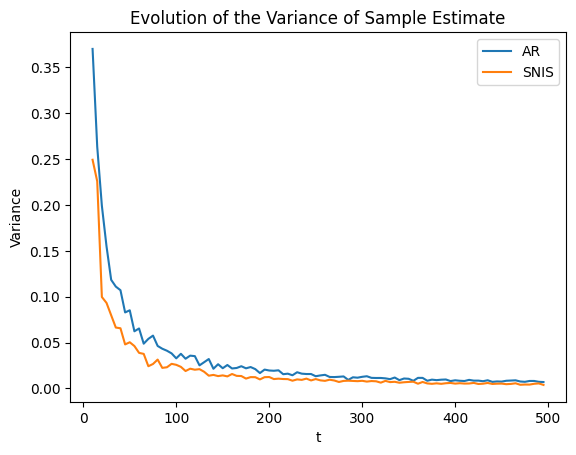

In [31]:
N = 200
trange = np.arange(10,500,5)
arvar, snisvar, armean, snismean = [], [], [], []
for t in trange:
    ar_est = ar_sampler.target_estimate(t, N)
    snis_est = snis_sampler.target_estimate(t, N)
    arvar.append(np.var(ar_est))
    snisvar.append(np.var(snis_est))
    armean.append(np.mean(ar_est))
    snismean.append(np.mean(snis_est))
plt.plot(trange, arvar, label='AR')
plt.plot(trange, snisvar, label='SNIS')
plt.title('Evolution of the Variance of Sample Estimate')
plt.xlabel('t')
plt.ylabel('Variance')
plt.legend()

In this next set of experiments, we consider the "combined" estimator by involving the rejected samples from AR, which can be computed by setting `recycle=True` in the `target_estimate` function of the rejection sampler. 

Again we compare the variances of the estimators against $t$. We also compare the mean of the estimators here. We see that for reasonably big $t$, the SNIS estimator almost always (at least for those we have tested) has a slightly better variance. The combined estimator occasionally outperforms, in terms of variance, AR when $t\leq 200$, but overall (at least for the $t$ we have experimented on) its performance is not as good as the other two. As for the mean, all of them seems to be converging to the same place.

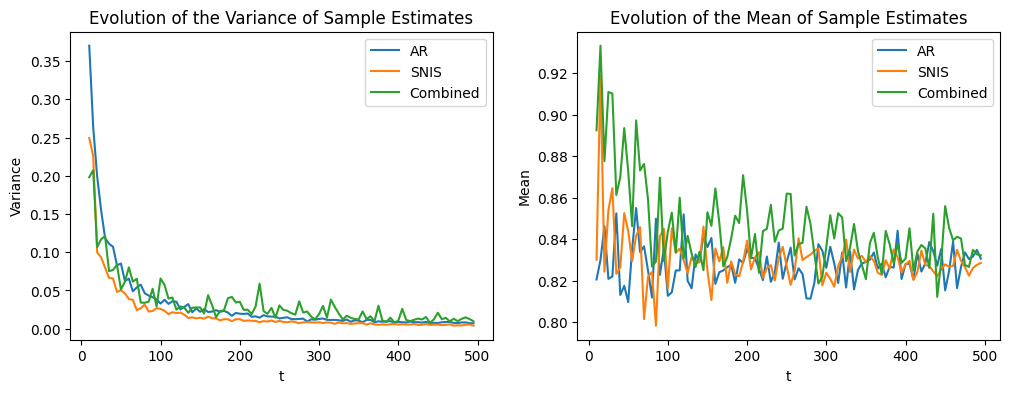

In [32]:
N = 200
trange = np.arange(10,500,5)
combvar, combmean = [], []
for t in trange:
    comb_est = ar_sampler.target_estimate(t,N,recycle=True)
    combvar.append(np.var(comb_est))
    combmean.append(np.mean(comb_est))

fig, axs = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(12)
axs[0].plot(trange, arvar, label='AR')
axs[0].plot(trange, snisvar, label='SNIS')
axs[0].plot(trange, combvar, label='Combined')
axs[0].set_title('Evolution of the Variance of Sample Estimates')
axs[0].set_xlabel('t')
axs[0].set_ylabel('Variance')
axs[0].legend()

axs[1].plot(trange, armean, label='AR')
axs[1].plot(trange, snismean, label='SNIS')
axs[1].plot(trange, combmean, label='Combined')
axs[1].set_title('Evolution of the Mean of Sample Estimates')
axs[1].set_xlabel('t')
axs[1].set_ylabel('Mean')
axs[1].legend()
print()